In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture

In [40]:
# wczytanie danych 
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")
test_X = test.iloc[:,1:]
test_y = test.iloc[:,0]

Pomysl jest nastepujacy. Skoro mamy powiedziane, że w traningu nie ma probek odstajaych to ozancza ze bedziemy chcieli jak najlepiej wytrenowac nasz model, by klsatry byly jak najczystrze. Można by oczywiscie przyjac ze robimy jeden duzy kalster, i potem przy tesowaniu wszytko co by bylo w pewnej ustalonej odlegości od niego uznalibysmy jako outlier. Jednak uwazam, że trzeba podajc taka decyzje na podstawie pewnych ekspetymentow. To, że nie ma odstajacych probek, nie oznacza, że możemy wyrózniec tylko jeden kalster. Raczej spodziewamy jak jakies malej liczby po to, żeby sie tez nie rozdrabniac za bardzo, lecz nie koniecznie wybor 1 jest najlepszy.

Zrzutujemy teraz zbior na płaszczynze za pomoca PCA, uzyjemy metryki silhouette. Preferuje ona kalstry okragłe. Oczywisci nie mozemy byc pewni, że oryginalny zbior zawiera "oble" klastry i przedstawienie go zredukawanego do 2 wymiarow nie potwierdza, że jest on ma on "wypukle' klastry, ale to lepsze niz nic

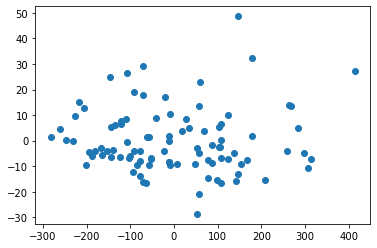

In [3]:
pca = PCA(n_components=2)
pca.fit(train)
pca_train = pca.transform(train)
XY = pd.DataFrame(pca_train)
plt.scatter(XY[0], XY[1])
plt.show()

In [4]:
def chose_components(n, X, score_fun):
    scores = []  
    for i in range(2, n):
        gmm = GMM(n_components = i, covariance_type = 'full')
        labels = gmm.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    plt.plot(range(2, n), scores)
    return scores

[0.29768430900930104,
 0.5626698628047635,
 0.5353149066996757,
 0.48699250950933143,
 0.45445129544917434,
 0.4734087175663116,
 0.4761300274328743,
 0.4080133410849341]

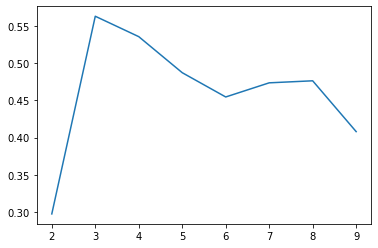

In [5]:
from sklearn.metrics import silhouette_score
chose_components(10, train, silhouette_score)

Widzimy, że najbardziej obiecujacy jest 3. Bedziemy na koniec strawadzac jak wygadla sytuacja dla `n_components = 1`. Ale w tej chwili będzmiemy sie trzymac podzialu na 3. Innym podejsciem by bylo posiadanie zbioru walidacyjengo wraz z kalsami i korygowanie na nim liczby klastow. Poniewaz tak nie jest posluzymy sie wykresami aby stwierdzic ktore probi sa odstacje

In [32]:
gmm = GMM(n_components = 3, covariance_type = 'full')
gmm.fit(train)

GaussianMixture(n_components=3)

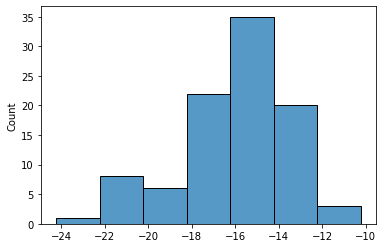

In [33]:
score_tr = gmm.score_samples(train) # Compute the weighted log probabilities for each sample.
sns.histplot(score_tr,binwidth=2)
plt.show()

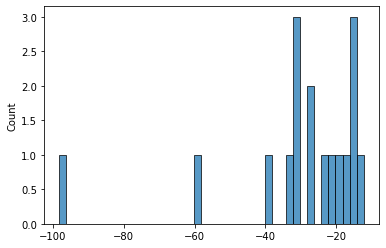

In [34]:
score_val = gmm.score_samples(val) # Compute the weighted log probabilities for each sample.
sns.histplot(score_val,binwidth=2)
plt.show()

Widzimy ze to na pewno bedzie cos okolo -40. Mozemy teraz sprawdzic jak tak wartosc przeklada sie do wyodrebnienia outlierow

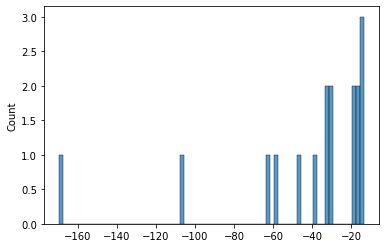

In [41]:
score_test_X = gmm.score_samples(test_X) # Compute the weighted log probabilities for each sample.
sns.histplot(score_test_X,binwidth=2)
plt.show()

Czas na nasze przewidywania

In [50]:
test_y_hat = (score_test_X < -40).astype(int)

In [53]:
print(classification_report(test_y, test_y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



No trzeba przyznac, że lepiej być nie moglo. Zbior byl wprawdzie i ciezko mi stiwerdzić czy wystepuje tutaj overfitting, a moze nawet underfitting, bo przeciez odrzucamy na podtwie jedenj wartssci co nie jest skopliowane. Tak czy inaczej udalo nam sie odnaleźć utlinery za pomoca tej techiniki, a wyniki sa lepiej niz dobre :)